# Word2Vec - Exploration and Models

**Author**: Marcelo Scatena
***
March 2022

In [135]:
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.manifold import TSNE

#Preprocessing
import nltk
from nltk.collocations import *
from nltk import word_tokenize
import string

#Data Modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

#Data Evaluation 
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                             accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score

#Word2Vec
from gensim.models import Word2Vec

# Spacy
from scipy import spatial

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

In [2]:
def print_cm_with_labels(y_true, 
                         y_pred):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    disp_labels = ['True', 'Fake']
    cm = confusion_matrix(y_true, y_pred, normalize=True)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(disp_labels)
    return None

## Load and Clean data

When working with word embeddings we don't usually have to undergo the whole cleaning of the data as we did with categorical encoding. Here the words will have pre-assigned values, and they are important to add meaning and context to the sentences. What'll I'll do is just shape it enough so it can undergo embedding.

In [56]:
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
raw_train = pd.read_csv('data/train2.tsv', sep='\t', names=col_names)
raw_test = pd.read_csv('data/test2.tsv', sep='\t', names=col_names)
raw_val = pd.read_csv('data/val2.tsv', sep='\t', names=col_names)

In [58]:
def drop_na(df):
    df = df.dropna(subset=['statement'], axis=0)
    return df

def drop_duplicated(df):
    df = df.drop_duplicates()
    return df

def label(df):
    df['label'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0})
    return df

def drop_features(df):
    df = df[['statement','label']]
    return df

def reset_index(df):
    df['statement'] = df['statement'].apply(lambda x: x.lower())
    return df

def remove_punctuation(df):
    df['statement'] = df['statement'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
    return df

def lower_case(df):
    df = df.reset_index(drop=True)
    return df

def tokenize_(df):
    df['statement'] = df['statement'].map(word_tokenize)
    return df

In [66]:
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('drop_features', FunctionTransformer(drop_features)),
    ('reset_index', FunctionTransformer(reset_index)),
    ('lower_case', FunctionTransformer(lower_case)),
    ('remove_punctuation', FunctionTransformer(remove_punctuation)),
    ('tokenize_', FunctionTransformer(tokenize_))
])

In [67]:
df_train_clean = cleaning_pipeline.fit_transform(raw_train)
df_val_clean = cleaning_pipeline.transform(raw_val)
df_test_clean = cleaning_pipeline.transform(raw_test)

In [68]:
X_train_clean = df_train_clean['statement']
y_train_clean = df_train_clean['label']
X_val_clean = df_val_clean['statement']
y_val_clean = df_val_clean['label']
X_test_clean = df_test_clean['statement']
y_test_clean = df_test_clean['label']

In [69]:
df_train_clean.head()

,statement,label
0,"[says, the, annies, list, political, group, su...",0
1,"[when, did, the, decline, of, coal, start, it,...",1
2,"[hillary, clinton, agrees, with, john, mccain,...",1
3,"[health, care, reform, legislation, is, likely...",0
4,"[the, economic, turnaround, started, at, the, ...",1


In [70]:
# Name a variable for the W2vec model
X_train_w2v = X_train_clean

# Creates the w2v model
w2v_model = Word2Vec(X_train_w2v, window=5, min_count=1, workers=4)
w2v_model.train(X_train_w2v, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

wv = w2v_model.wv

In [71]:
# We have a dictionary with all words in the train data
for word, value in w2v_model.wv.key_to_index.items():
    if value < 5:
        print(f'{word}: {value}')

the: 0
in: 1
of: 2
to: 3
a: 4


In [72]:
# Number of unique words in the train data
vocab_len = len(w2v_model.wv)
vocab_len

13453

In [73]:
# Transforms each word in an array of 100 dimensions
X = w2v_model.wv[w2v_model.wv.key_to_index]
len(X[0])

100

In [74]:
# Use PCA to reduce the dimensionality of the array from 100 to 2
pca = PCA(n_components=2)
result = pca.fit_transform(X)

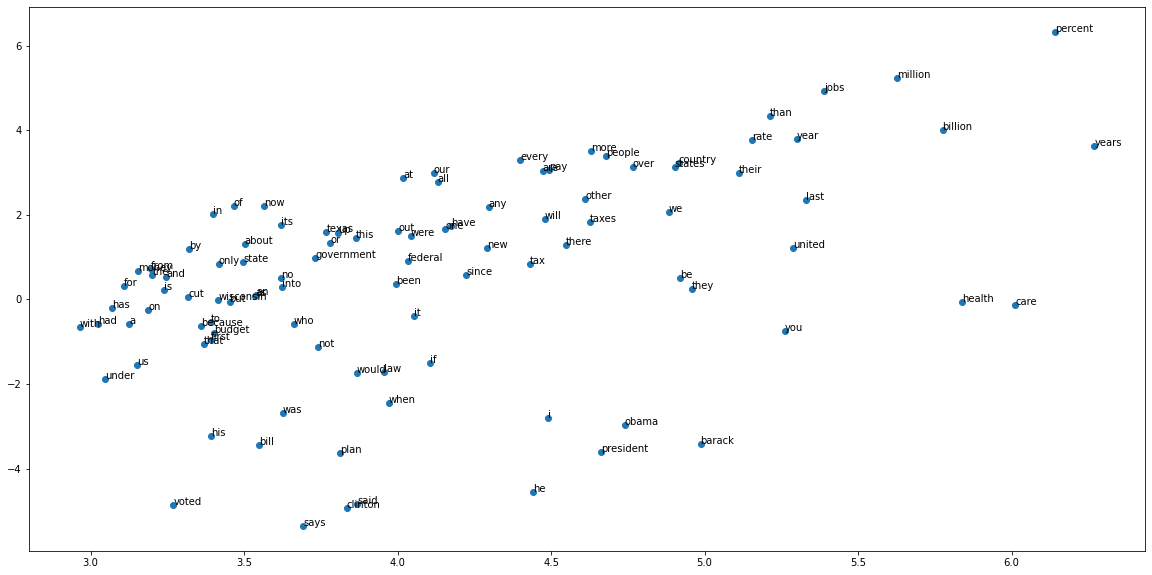

In [75]:
# Vizualize the first 50 words in the dictionary in 2 dimensions
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(result[:100, 0], result[:100, 1])
words = list(w2v_model.wv.key_to_index)
for i, word in enumerate(words[:100]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

#### Examinig Vectors

In [76]:
# Create a function to show most similar words, or are closest to the given word
def show_most_similar(word, length=10):
    return wv.most_similar(word, topn=length)

In [78]:
show_most_similar('trump')[:5]

[('donald', 0.924665093421936),
 ('saysabout', 0.9229723811149597),
 ('trumps', 0.900431752204895),
 ('sanders', 0.8915305137634277),
 ('feinstein', 0.8803153038024902)]

In [79]:
show_most_similar('war')[:5]

[('iraq', 0.9224121570587158),
 ('ii', 0.9221916794776917),
 ('came', 0.9157782793045044),
 ('beginning', 0.9038121700286865),
 ('ever', 0.8994254469871521)]

In [80]:
show_most_similar('election')[:5]

[('cycle', 0.9358399510383606),
 ('november', 0.9349574446678162),
 ('during', 0.930069625377655),
 ('term', 0.9214144945144653),
 ('2012', 0.9203440546989441)]

In [81]:
show_most_similar('president')[:5]

[('barack', 0.968543291091919),
 ('administration', 0.9226271510124207),
 ('thensen', 0.9048345685005188),
 ('contrast', 0.8628866672515869),
 ('hussein', 0.862370491027832)]

In [82]:
show_most_similar('health')[:5]

[('affordable', 0.9488025903701782),
 ('uncompensated', 0.9461062550544739),
 ('preventive', 0.9250509142875671),
 ('ration', 0.9246290326118469),
 ('intensive', 0.9239700436592102)]

In [83]:
# Create list with all words
X_train_tokenized = word_tokenize(' '.join(X_train_w2v.apply(lambda x: ' '.join(x))))
X_train_tokenized[:5]

['says', 'the', 'annies', 'list', 'political']

In [84]:
len(X_train_tokenized)

183973

In [85]:
# Use BigramAssocMeasures from nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(X_train_tokenized)
bigrams = finder.score_ngrams(bigram_measures.raw_freq)

In [86]:
# Display the top 20 bigrams
bigrams[:20]

[(('in', 'the'), 0.00746305164344768),
 (('of', 'the'), 0.005669310170514152),
 (('percent', 'of'), 0.003158072108407212),
 (('health', 'care'), 0.0021796676686252872),
 (('to', 'the'), 0.0019296309784587956),
 (('more', 'than'), 0.0019241953982377848),
 (('for', 'the'), 0.0017393856707234214),
 (('on', 'the'), 0.0016632875476292716),
 (('the', 'united'), 0.0016198029058611862),
 (('united', 'states'), 0.0016198029058611862),
 (('barack', 'obama'), 0.0015273980421040044),
 (('the', 'state'), 0.0013317171541476194),
 (('is', 'the'), 0.0011577785870752774),
 (('out', 'of'), 0.0010436314024340528),
 (('we', 'have'), 0.0010327602419920314),
 (('the', 'last'), 0.0010110179211079886),
 (('the', 'us'), 0.0009675332793399031),
 (('says', 'the'), 0.0009403553782348497),
 (('and', 'the'), 0.0009294842177928283),
 (('hillary', 'clinton'), 0.0009240486375718176)]

In [38]:
# target = y_train_clean
# data = X_train_clean.map(word_tokenize).values

array([list(['Says', 'the', 'Annies', 'List', 'political', 'group', 'supports', 'third-trimester', 'abortions', 'on', 'demand', '.']),
       list(['When', 'did', 'the', 'decline', 'of', 'coal', 'start', '?', 'It', 'started', 'when', 'natural', 'gas', 'took', 'off', 'that', 'started', 'to', 'begin', 'in', '(', 'President', 'George', 'W.', ')', 'Bushs', 'administration', '.']),
       list(['Hillary', 'Clinton', 'agrees', 'with', 'John', 'McCain', '``', 'by', 'voting', 'to', 'give', 'George', 'Bush', 'the', 'benefit', 'of', 'the', 'doubt', 'on', 'Iran', '.', "''"]),
       ...,
       list(['Says', 'an', 'alternative', 'to', 'Social', 'Security', 'that', 'operates', 'in', 'Galveston', 'County', ',', 'Texas', ',', 'has', 'meant', 'that', 'participants', 'will', 'retire', 'with', 'a', 'whole', 'lot', 'more', 'money', 'than', 'under', 'Social', 'Security', '.']),
       list(['On', 'lifting', 'the', 'U.S.', 'Cuban', 'embargo', 'and', 'allowing', 'travel', 'to', 'Cuba', '.']),
       list([

### Glove

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. It was developed as an opens source project at Stanford University. You can find their project [here](https://nlp.stanford.edu/projects/glove/) and the citation in the references.

In [96]:
total_vocabulary = set(word for headline in X_train_clean.values for word in headline)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 13453 unique tokens in the dataset.


In [89]:
# Creating a glove dictionary with 50 dimensions
glove_50 = {}
with open('./embeddings/glove.6B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove_50[word] = vector

In [94]:
# Glove 50d representation of the word 'trump'
glove_50['trump']

array([ 0.45769  ,  0.85191  ,  0.31098  ,  1.3478   , -0.021703 ,
       -0.05467  , -0.17405  , -0.71014  , -0.57441  ,  0.49786  ,
       -0.89382  ,  0.58661  , -0.77013  ,  0.23779  ,  0.37652  ,
        1.3668   ,  0.34667  ,  0.082452 ,  0.17561  ,  0.056062 ,
        0.50818  ,  0.33751  , -0.8517   ,  0.034619 , -0.57237  ,
       -1.1534   , -0.54159  ,  0.24328  ,  0.018737 , -0.58645  ,
        0.15261  ,  0.53372  , -0.27601  ,  0.065097 ,  0.3968   ,
       -0.62892  ,  0.0046726,  0.081347 , -0.32579  , -0.60933  ,
       -0.36464  ,  0.17591  ,  0.0050718,  1.3606   , -0.78583  ,
        0.083121 , -0.75184  , -0.74226  ,  0.77053  ,  0.26394  ],
      dtype=float32)

In [91]:
# Creating a glove dictionary with 200 dimensions
glove_200 = {}
with open("./embeddings/glove.6B.200d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove_200[word] = vector

In [95]:
# Glove 200 representation of the word 'trump'
glove_200['trump']

array([-8.0178e-01,  1.6873e-01,  1.7636e-01, -1.5029e-01, -1.0933e-01,
        3.5040e-01,  8.3435e-01,  1.8739e-01,  1.8220e-03,  4.9690e-01,
       -2.6810e-01, -4.6612e-01, -3.8275e-02, -1.4349e-01,  5.2981e-02,
       -7.2477e-02, -4.8277e-01,  4.6729e-01,  1.3453e-01,  2.2992e-02,
        1.7057e-01,  9.6488e-01,  5.5291e-02,  6.1712e-02, -5.8483e-02,
       -9.0204e-02, -3.6331e-01, -2.8411e-01,  3.8108e-01, -6.8041e-01,
       -5.2522e-01,  3.1860e-01, -2.8973e-01,  1.8741e-01, -2.6651e-02,
        4.2033e-03, -1.4390e-01, -1.8431e-01, -6.2648e-02,  2.4534e-01,
        2.0507e-02, -1.6691e-02, -5.5270e-02, -1.6432e-01,  4.6906e-02,
        5.8332e-01,  2.2994e-01, -5.8691e-02, -2.6903e-01,  6.6086e-01,
        4.8328e-02, -6.5918e-04, -7.2490e-02,  1.4336e-01,  1.5273e-01,
       -1.7361e-01,  1.9548e-01, -5.5141e-02,  2.6366e-01, -7.2816e-02,
       -2.2922e-01,  1.4436e+00, -5.1534e-01,  4.7246e-01,  1.9811e-01,
       -1.8947e-01, -1.1231e+00,  7.2710e-01,  5.5243e-01,  2.05

Scipy allows to use euclidean distance to add or subtract words in the multi dimensional space. I didn't use this for any models, but it's an interesting thing to see:

In [104]:
def find_closest_embeddings(embedding, cutoff=25):
    return sorted(glove_200.keys(), key=lambda token: spatial.distance.euclidean(glove_200[token], embedding))

In [116]:
print(find_closest_embeddings(
    glove_200["president"] - glove_200["obama"] + glove_200["woman"]
)[:5])

['woman', 'president', 'man', 'wife', 'mother']


### Tsne

Tsne (t-distributed stochastic neighbourhood embedding), is a method for dimensionality reduction, like PCA, that tries to get a point from a higher dimension to a lower one while preserving it's neighbours.I found their differences easily discribed in [this](https://www.geeksforgeeks.org/difference-between-pca-vs-t-sne/) small article.

In [119]:
tsne = TSNE(n_components=2, random_state=0)

# Creates list of words and list of arrays of glove dictionary
tokens = list(glove_200.keys())
vectors = [glove_200[token] for token in tokens]
# Reduces dimensionality of data
Y = tsne.fit_transform(vectors[:200])

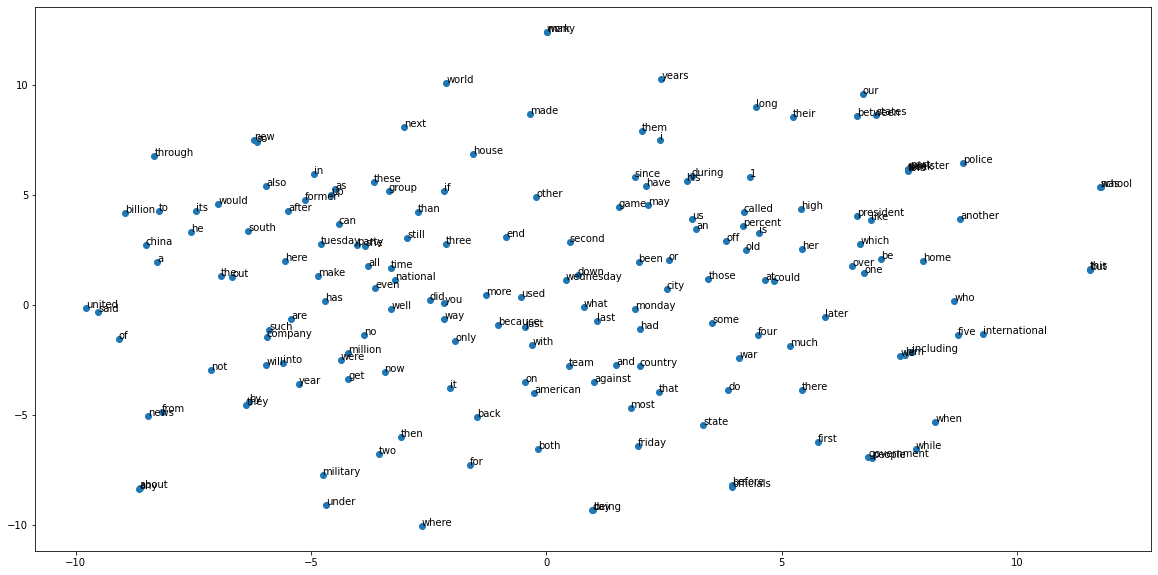

In [124]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(Y[30:, 0], Y[30:, 1])
for label, x, y in zip(tokens, Y[30:, 0], Y[30:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Creating Mean Word Embeddings

He're I'm creating a mean embedding vectorizer class, so I can use it in scikit-learn pipelines. I'll create one for the 50 dimension glove, and one for the 200 dimension one, and will run a few models in a pipeline to find their accuracy.<br />
Code for this part was inspired by the [Flatiron material](https://github.com/learn-co-curriculum/dsc-classification-with-word-embeddings-codealong/tree/master) in the subject.

In [127]:
class W2vVectorizer_50(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove_50))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [128]:
class W2vVectorizer_200(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove_200))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [131]:
rf_50 =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer_50(glove_50)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=22, ccp_alpha=0.1, verbose=True))])
svc_50 = Pipeline([('Word2Vec Vectorizer', W2vVectorizer_50(glove_50)),
                ('Support Vector Machine', SVC())])
lr_50 = Pipeline([('Word2Vec Vectorizer', W2vVectorizer_50(glove_50)),
              ('Logistic Regression', LogisticRegression(C=0.1, solver='liblinear'))])
sgd_50 = Pipeline([('Vectorizer', W2vVectorizer_50(glove_50)),
                ('Stochastic Gradient Descent', SGDClassifier(fit_intercept=False, early_stopping=True, alpha=0.01, loss='log'))])

In [133]:
models_50 = [('Random Forest', rf_50),
          ('Support Vector Machine', svc_50),
          ('Logistic Regression', lr_50),
          ('Stochastic Gradient Descent', sgd_50)]

In [136]:
scores_50 = [(name, cross_val_score(model, X_train_clean.values, y_train_clean, cv=2).mean()) for name, model, in models_50]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [139]:
scores_50

[('Random Forest', 0.56171875),
 ('Support Vector Machine', 0.59794921875),
 ('Logistic Regression', 0.59755859375),
 ('Stochastic Gradient Descent', 0.5876953125)]

The accuracy of these models are no better than the ones I've done with categorical encoding.

In [137]:
rf_200 =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer_200(glove_200)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=22, ccp_alpha=0.1, verbose=True))])
svc_200 = Pipeline([('Word2Vec Vectorizer', W2vVectorizer_200(glove_200)),
                ('Support Vector Machine', SVC())])
lr_200 = Pipeline([('Word2Vec Vectorizer', W2vVectorizer_200(glove_200)),
              ('Logistic Regression', LogisticRegression(C=0.1, solver='liblinear'))])
sgd_200 = Pipeline([('Vectorizer', W2vVectorizer_200(glove_200)),
                ('Stochastic Gradient Descent', SGDClassifier(fit_intercept=False, early_stopping=True, alpha=0.01, loss='log'))])

In [138]:
models_200 = [('Random Forest', rf_200),
          ('Support Vector Machine', svc_200),
          ('Logistic Regression', lr_200),
          ('Stochastic Gradient Descent', sgd_200)]

In [140]:
scores_200 = [(name, cross_val_score(model, X_train_clean.values, y_train_clean, cv=2).mean()) for name, model, in models_200]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [141]:
scores_200

[('Random Forest', 0.56171875),
 ('Support Vector Machine', 0.6126953125),
 ('Logistic Regression', 0.6078125000000001),
 ('Stochastic Gradient Descent', 0.5962890624999999)]

Though these accuracies get slightly better, their still on par with the categorical encoding ones.

In [185]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint

In [163]:
y_t = pd.get_dummies(y_train_clean).values
y_v = pd.get_dummies(y_val_clean).values

In [164]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train_clean))

list_tokenized_train = tokenizer.texts_to_sequences(X_train_clean)
list_tokenized_val = tokenizer.texts_to_sequences(X_val_clean)

X_t = sequence.pad_sequences(list_tokenized_train, maxlen=100)
X_v = sequence.pad_sequences(list_tokenized_val, maxlen=100)

In [165]:
model = Sequential()

In [166]:
embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))

In [167]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [168]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_4 (LSTM)               (None, None, 25)          15400     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 25)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                1300      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                      

In [169]:
history = model.fit(X_t, y, epochs=10, batch_size=32, validation_data=(X_v, y_v))

Epoch 1/10
320/320 [==============================] - 19s 52ms/step - loss: 0.6696 - accuracy: 0.5865 - val_loss: 0.6581 - val_accuracy: 0.6223
Epoch 2/10
320/320 [==============================] - 16s 51ms/step - loss: 0.5775 - accuracy: 0.7061 - val_loss: 0.6742 - val_accuracy: 0.6098
Epoch 3/10
320/320 [==============================] - 17s 52ms/step - loss: 0.4251 - accuracy: 0.8115 - val_loss: 0.8055 - val_accuracy: 0.5787
Epoch 4/10
320/320 [==============================] - 16s 51ms/step - loss: 0.2813 - accuracy: 0.8825 - val_loss: 1.0559 - val_accuracy: 0.5678
Epoch 5/10
320/320 [==============================] - 16s 50ms/step - loss: 0.1788 - accuracy: 0.9295 - val_loss: 1.4341 - val_accuracy: 0.5732
Epoch 6/10
320/320 [==============================] - 16s 51ms/step - loss: 0.1113 - accuracy: 0.9579 - val_loss: 1.8666 - val_accuracy: 0.5872
Epoch 7/10
320/320 [==============================] - 18s 55ms/step - loss: 0.0765 - accuracy: 0.9697 - val_loss: 2.0000 - val_accuracy:

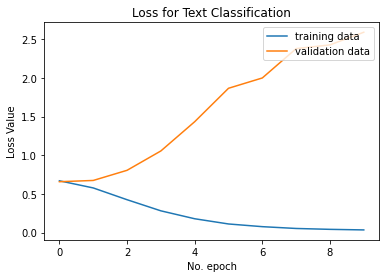

In [170]:
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

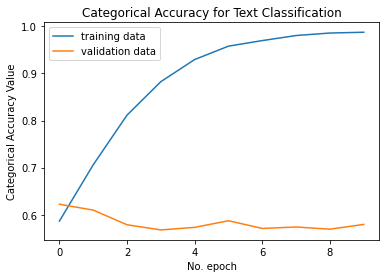

In [171]:
plt.plot(history.history['accuracy'], label='training data')
plt.plot(history.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [180]:
model2 = Sequential()
embedding_size = 128
model2.add(Embedding(20000, embedding_size))
model2.add(LSTM(25, return_sequences=True))
model2.add(GlobalMaxPool1D())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))
model2.layers[0].trainable = False

In [181]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [182]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_7 (LSTM)               (None, None, 25)          15400     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 50)                1300      
                                                                 
 dense_15 (Dense)            (None, 2)                 102       
                                                                 
Total params: 2,576,802
Trainable params: 16,802
Non-trainable params: 2,560,000
_______________________________________

In [186]:
#Save the best model
filepath = 'nn_models/rnn_100_epoch.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

In [188]:
history2 = model2.fit(X_t, y, epochs=30, batch_size=32, validation_data=(X_v, y_v), callbacks=callbacks)

Epoch 1/30
319/320 [============================>.] - ETA: 0s - loss: 0.5914 - accuracy: 0.6824
Epoch 1: val_loss did not improve from 0.66306
320/320 [==============================] - 8s 25ms/step - loss: 0.5914 - accuracy: 0.6825 - val_loss: 0.6726 - val_accuracy: 0.6129
Epoch 2/30
320/320 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.6968
Epoch 2: val_loss did not improve from 0.66306
320/320 [==============================] - 8s 26ms/step - loss: 0.5787 - accuracy: 0.6968 - val_loss: 0.6784 - val_accuracy: 0.5942
Epoch 3/30
318/320 [============================>.] - ETA: 0s - loss: 0.5692 - accuracy: 0.6998
Epoch 3: val_loss did not improve from 0.66306
320/320 [==============================] - 8s 25ms/step - loss: 0.5688 - accuracy: 0.7002 - val_loss: 0.6844 - val_accuracy: 0.5974
Epoch 4/30
319/320 [============================>.] - ETA: 0s - loss: 0.5562 - accuracy: 0.7145
Epoch 4: val_loss did not improve from 0.66306
320/320 [=======================

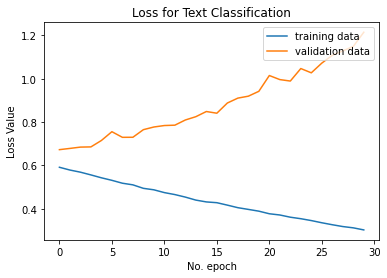

In [189]:
plt.plot(history2.history['loss'], label='training data')
plt.plot(history2.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

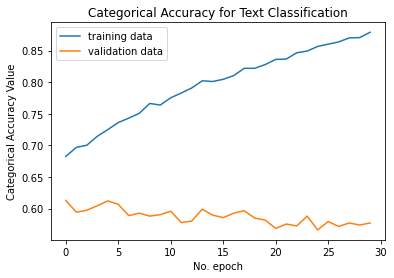

In [190]:
plt.plot(history2.history['accuracy'], label='training data')
plt.plot(history2.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [198]:
model3 = Sequential()
embedding_size = 128
model3.add(Embedding(20000, embedding_size))
model3.add(LSTM(25, return_sequences=True))
model3.add(GlobalMaxPool1D())
model3.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model3.add(Dense(2, activation='sigmoid'))

model3.layers[0].trainable = False

model3.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 128)         2560000   
                                                                 
 lstm_13 (LSTM)              (None, None, 25)          15400     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_24 (Dense)            (None, 50)                1300      
                                                                 
 dense_25 (Dense)            (None, 2)                 102       
                                                                 
Total params: 2,576,802
Trainable params: 16,802
Non-trainable params: 2,560,000
______________________________________

In [206]:
#Save the best model
filepath = './nn_models/rnn_regularization.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]
history3 = model3.fit(X_t, y, epochs=30, batch_size=32, validation_data=(X_v, y_v))

Epoch 1/30
320/320 [==============================] - 8s 25ms/step - loss: 0.6809 - accuracy: 0.5617 - val_loss: 0.6912 - val_accuracy: 0.5202
Epoch 2/30
320/320 [==============================] - 8s 24ms/step - loss: 0.6764 - accuracy: 0.5705 - val_loss: 0.6841 - val_accuracy: 0.5498
Epoch 3/30
320/320 [==============================] - 8s 25ms/step - loss: 0.6740 - accuracy: 0.5812 - val_loss: 0.6850 - val_accuracy: 0.5857
Epoch 4/30
320/320 [==============================] - 8s 24ms/step - loss: 0.6728 - accuracy: 0.5913 - val_loss: 0.6796 - val_accuracy: 0.5818
Epoch 5/30
320/320 [==============================] - 8s 24ms/step - loss: 0.6711 - accuracy: 0.5899 - val_loss: 0.6795 - val_accuracy: 0.5693
Epoch 6/30
320/320 [==============================] - 7s 23ms/step - loss: 0.6684 - accuracy: 0.5897 - val_loss: 0.6774 - val_accuracy: 0.5958
Epoch 7/30
320/320 [==============================] - 7s 23ms/step - loss: 0.6670 - accuracy: 0.5891 - val_loss: 0.6771 - val_accuracy: 0.5849

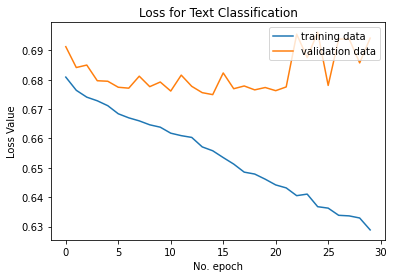

In [207]:
plt.plot(history3.history['loss'], label='training data')
plt.plot(history3.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

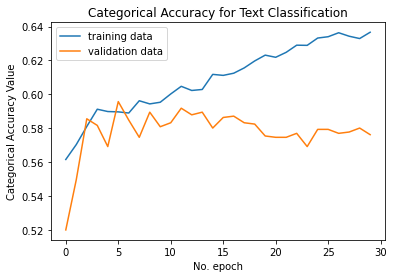

In [208]:
plt.plot(history3.history['accuracy'], label='training data')
plt.plot(history3.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [211]:
model4 = Sequential()
embedding_size = 128
model4.add(Embedding(20000, embedding_size))
model4.add(LSTM(25, return_sequences=True))
model4.add(Dropout(0.1))
model4.add(GlobalMaxPool1D())
model4.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model4.add(Dense(2, activation='sigmoid'))

model4.layers[0].trainable = False

model4.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 128)         2560000   
                                                                 
 lstm_15 (LSTM)              (None, None, 25)          15400     
                                                                 
 dropout_11 (Dropout)        (None, None, 25)          0         
                                                                 
 global_max_pooling1d_11 (Gl  (None, 25)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_28 (Dense)            (None, 50)                1300      
                                                                 
 dense_29 (Dense)            (None, 2)                 102       
                                                     

In [212]:
#Save the best model
filepath = './nn_models/rnn_regularization.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]
history4 = model4.fit(X_t, y, epochs=30, batch_size=32, validation_data=(X_v, y_v))

Epoch 1/30
320/320 [==============================] - 12s 28ms/step - loss: 1.1232 - accuracy: 0.5613 - val_loss: 0.7190 - val_accuracy: 0.5202
Epoch 2/30
320/320 [==============================] - 7s 23ms/step - loss: 0.6889 - accuracy: 0.5617 - val_loss: 0.6926 - val_accuracy: 0.5202
Epoch 3/30
320/320 [==============================] - 8s 25ms/step - loss: 0.6804 - accuracy: 0.5644 - val_loss: 0.6828 - val_accuracy: 0.5818
Epoch 4/30
320/320 [==============================] - 8s 25ms/step - loss: 0.6765 - accuracy: 0.5727 - val_loss: 0.6822 - val_accuracy: 0.5561
Epoch 5/30
320/320 [==============================] - 8s 25ms/step - loss: 0.6722 - accuracy: 0.5854 - val_loss: 0.6861 - val_accuracy: 0.5935
Epoch 6/30
320/320 [==============================] - 8s 24ms/step - loss: 0.6718 - accuracy: 0.5787 - val_loss: 0.6793 - val_accuracy: 0.5802
Epoch 7/30
320/320 [==============================] - 8s 26ms/step - loss: 0.6695 - accuracy: 0.5938 - val_loss: 0.6772 - val_accuracy: 0.576

In [ ]:
plt.plot(history4.history['loss'], label='training data')
plt.plot(history4.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.plot(history4.history['accuracy'], label='training data')
plt.plot(history4.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [221]:
model5 = Sequential()
embedding_size = 128
model5.add(Embedding(20000, embedding_size))
model5.add(LSTM(25, return_sequences=True))
model5.add(Dropout(0.1))
model5.add(GlobalMaxPool1D())
model5.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model5.add(Dense(2, activation='sigmoid'))

model5.layers[0].trainable = False

model5.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model5.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 128)         2560000   
                                                                 
 lstm_19 (LSTM)              (None, None, 25)          15400     
                                                                 
 dropout_13 (Dropout)        (None, None, 25)          0         
                                                                 
 global_max_pooling1d_14 (Gl  (None, 25)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_36 (Dense)            (None, 50)                1300      
                                                                 
 dense_37 (Dense)            (None, 2)                 102       
                                                     

In [222]:
#Save the best model
filepath = './nn_models/rnn_regularization.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]
history5 = model5.fit(X_t, y, epochs=30, batch_size=32, validation_data=(X_v, y_v))

Epoch 1/30
320/320 [==============================] - 10s 26ms/step - loss: 1.5774 - accuracy: 0.5617 - val_loss: 0.7422 - val_accuracy: 0.5202
Epoch 2/30
320/320 [==============================] - 7s 23ms/step - loss: 0.6956 - accuracy: 0.5617 - val_loss: 0.6957 - val_accuracy: 0.5202
Epoch 3/30
320/320 [==============================] - 8s 24ms/step - loss: 0.6843 - accuracy: 0.5617 - val_loss: 0.6918 - val_accuracy: 0.5202
Epoch 4/30
320/320 [==============================] - 8s 26ms/step - loss: 0.6807 - accuracy: 0.5617 - val_loss: 0.6870 - val_accuracy: 0.5202
Epoch 5/30
320/320 [==============================] - 9s 28ms/step - loss: 0.6770 - accuracy: 0.5627 - val_loss: 0.6807 - val_accuracy: 0.5202
Epoch 6/30
320/320 [==============================] - 10s 30ms/step - loss: 0.6753 - accuracy: 0.5715 - val_loss: 0.6817 - val_accuracy: 0.5740
Epoch 7/30
320/320 [==============================] - 10s 30ms/step - loss: 0.6732 - accuracy: 0.5790 - val_loss: 0.6815 - val_accuracy: 0.6

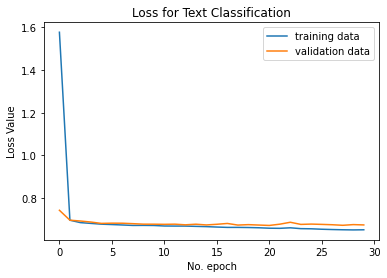

In [225]:
plt.plot(history5.history['loss'], label='training data')
plt.plot(history5.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

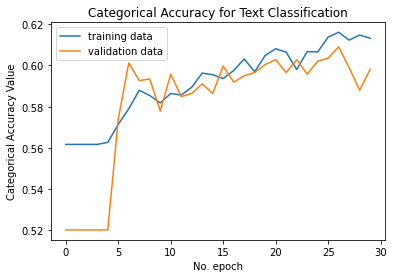

In [226]:
plt.plot(history5.history['accuracy'], label='training data')
plt.plot(history5.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [235]:
model6 = Sequential()
embedding_size = 128
model6.add(Embedding(20000, embedding_size))
model6.add(LSTM(25, return_sequences=True))
model6.add(Dropout(0.1))
model6.add(GlobalMaxPool1D())
model6.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model6.add(Dense(2, activation='sigmoid'))

model6.layers[0].trainable = False

model6.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model6.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 128)         2560000   
                                                                 
 lstm_23 (LSTM)              (None, None, 25)          15400     
                                                                 
 dropout_17 (Dropout)        (None, None, 25)          0         
                                                                 
 global_max_pooling1d_18 (Gl  (None, 25)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_45 (Dense)            (None, 50)                1300      
                                                                 
 dense_46 (Dense)            (None, 2)                 102       
                                                     

In [236]:
#Save the best model
filepath = './nn_models/rnn_regularization.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]
history6 = model6.fit(X_t, y, epochs=100, batch_size=32, validation_data=(X_v, y_v))

Epoch 1/100
320/320 [==============================] - 11s 28ms/step - loss: 1.5484 - accuracy: 0.5616 - val_loss: 0.7427 - val_accuracy: 0.5202
Epoch 2/100
320/320 [==============================] - 8s 25ms/step - loss: 0.6941 - accuracy: 0.5617 - val_loss: 0.6917 - val_accuracy: 0.5202
Epoch 3/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6827 - accuracy: 0.5617 - val_loss: 0.6897 - val_accuracy: 0.5202
Epoch 4/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6796 - accuracy: 0.5614 - val_loss: 0.6849 - val_accuracy: 0.5202
Epoch 5/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6757 - accuracy: 0.5764 - val_loss: 0.6832 - val_accuracy: 0.5935
Epoch 6/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6735 - accuracy: 0.5813 - val_loss: 0.6797 - val_accuracy: 0.5880
Epoch 7/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6728 - accuracy: 0.5818 - val_loss: 0.6788 - val_accuracy

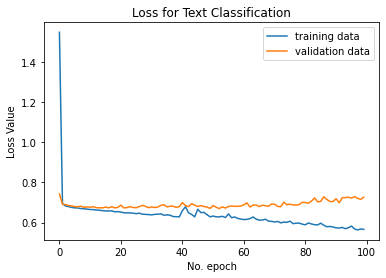

In [237]:
plt.plot(history6.history['loss'], label='training data')
plt.plot(history6.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

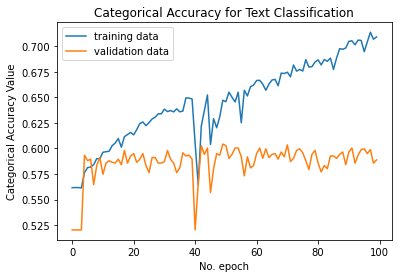

In [238]:
plt.plot(history6.history['accuracy'], label='training data')
plt.plot(history6.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [239]:
model7 = Sequential()
embedding_size = 128
model7.add(Embedding(20000, embedding_size))
model7.add(LSTM(25, return_sequences=True))
model7.add(Dropout(0.1))
model7.add(GlobalMaxPool1D())
model7.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model7.add(Dropout(0.1))
model7.add(Dense(2, activation='sigmoid'))

model7.layers[0].trainable = False

model7.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model7.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 128)         2560000   
                                                                 
 lstm_24 (LSTM)              (None, None, 25)          15400     
                                                                 
 dropout_18 (Dropout)        (None, None, 25)          0         
                                                                 
 global_max_pooling1d_19 (Gl  (None, 25)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_47 (Dense)            (None, 50)                1300      
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                     

In [240]:
#Save the best model
filepath = './nn_models/rnn_regularization.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]
history7 = model7.fit(X_t, y, epochs=100, batch_size=32, validation_data=(X_v, y_v))

Epoch 1/100
320/320 [==============================] - 13s 28ms/step - loss: 1.5508 - accuracy: 0.5595 - val_loss: 0.7437 - val_accuracy: 0.5202
Epoch 2/100
320/320 [==============================] - 8s 24ms/step - loss: 0.6949 - accuracy: 0.5617 - val_loss: 0.6940 - val_accuracy: 0.5202
Epoch 3/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6857 - accuracy: 0.5617 - val_loss: 0.6947 - val_accuracy: 0.5202
Epoch 4/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6834 - accuracy: 0.5617 - val_loss: 0.6900 - val_accuracy: 0.5202
Epoch 5/100
320/320 [==============================] - 7s 23ms/step - loss: 0.6843 - accuracy: 0.5617 - val_loss: 0.6926 - val_accuracy: 0.5202
Epoch 6/100
320/320 [==============================] - 8s 24ms/step - loss: 0.6796 - accuracy: 0.5623 - val_loss: 0.6912 - val_accuracy: 0.5202
Epoch 7/100
320/320 [==============================] - 8s 24ms/step - loss: 0.6772 - accuracy: 0.5696 - val_loss: 0.6847 - val_accuracy

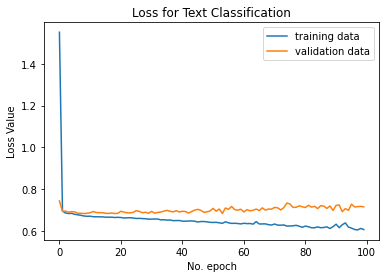

In [241]:
plt.plot(history7.history['loss'], label='training data')
plt.plot(history7.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

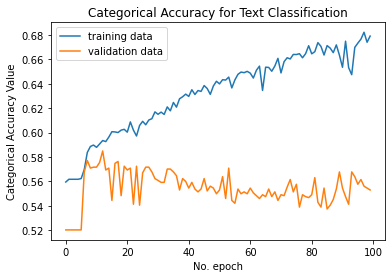

In [242]:
plt.plot(history7.history['accuracy'], label='training data')
plt.plot(history7.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

##### References:<br />
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. [GloVe: Global Vectors for Word Representation](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fnlp.stanford.edu%2Fpubs%2Fglove.pdf&clen=2618397).